In [6]:
import os.path as op
import numpy as np
import pylab as pl
import healpy as hp
import scipy as sp
from fgbuster.algebra import comp_sep,W,W_dB,W_dBdB,_utmv,_mmm,_mmv
from fgbuster.mixingmatrix import MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix, xForecast
from fgbuster.cosmology import _get_Cl_cmb, _get_Cl_noise

__all__ = [
    'xForecast',
]


def xForecast(components, instrument, d_fgs, lmin, lmax,Alens=1.0, r=0.001, make_figure=False,**minimize_kwargs):
    
    # Preliminaries
    instrument = standardize_instrument(instrument)
    nside = hp.npix2nside(d_fgs.shape[-1])
    n_stokes = d_fgs.shape[1]
    n_freqs = d_fgs.shape[0]
    invN = np.diag(hp.nside2resol(nside, arcmin=True) / (instrument.depth_p))**2
    mask = d_fgs[0, 0, :] != 0.
    fsky = mask.astype(float).sum() / mask.size
    ell = np.arange(lmin, lmax+1)
    

    ############################################################################
    # 1. Component separation using the noise-free foregrounds templare
    # grab the max-L spectra parameters with the associated error bars
   
    A = MixingMatrix(*components)
    A_ev = A.evaluator(instrument.frequency)
    A_dB_ev = A.diff_evaluator(instrument.frequency)

    x0 = np.array([x for c in components for x in c.defaults])
    if n_stokes == 3:  # if T and P were provided, extract P
        d_comp_sep = d_fgs[:, 1:, :]
    else:
        d_comp_sep = d_fgs

    res = comp_sep(A_ev, d_comp_sep.T, invN, A_dB_ev, A.comp_of_dB, x0, **minimize_kwargs)

    res.params = A.params
    res.s = res.s.T
    A_maxL = A_ev(res.x) 
    A_dB_maxL = A_dB_ev(res.x)
    A_dBdB_maxL = A.diff_diff_evaluator(instrument.frequency)(res.x)



    ###########################################################################
    #2. Estimate noise after component separation
    ## A^T N_ell^-1 A
   
    i_cmb = A.components.index('CMB')
    Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[i_cmb, i_cmb, lmin:]

    ############################################################################
    # 3. Compute spectra of the input foregrounds maps
    ### TO DO: which size for Cl_fgs??? N_spec != 1 ? 

    if n_stokes == 3:  
        d_spectra = d_fgs
    else:  # Only P is provided, add T for map2alm
        d_spectra = np.zeros((n_freqs, 3, d_fgs.shape[2]), dtype=d_fgs.dtype)
        d_spectra[:, 1:] = d_fgs

    # Compute cross-spectra
    almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
    Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=d_fgs.dtype)
    for f1 in range(n_freqs):
        for f2 in range(n_freqs):
            if f1 > f2:
                Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
            else:
                Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

    Cl_fgs = Cl_fgs[..., lmin:] / fsky

    ############################################################################
    # 4. Estimate the statistical and systematic foregrounds residuals
  
    W_maxL = W(A_maxL, invN=invN)[i_cmb, :]
    W_dB_maxL = W_dB(A_maxL, A_dB_maxL, A.comp_of_dB, invN=invN)[:, i_cmb]
    W_dBdB_maxL = W_dBdB(A_maxL, A_dB_maxL, A_dBdB_maxL,A.comp_of_dB, invN=invN)[:, :, i_cmb]

   

    V_maxL = np.einsum('ij,ij...->...', res.Sigma, W_dBdB_maxL)


    

    # Check dimentions
    assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]
                       == W_dBdB_maxL.shape[2:] == V_maxL.shape)
    assert (len(res.params) == W_dB_maxL.shape[0] 
                            == W_dBdB_maxL.shape[0] == W_dBdB_maxL.shape[1])

    # elementary quantities defined in Stompor, Errard, Poletti (2016)
    Cl_xF = {}
    Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)
    Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)
    Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
    Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
    Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)



    # bias and statistical foregrounds residuals
    res.noise = Cl_noise
    res.bias = Cl_xF['yy'] + 2 * Cl_xF['yz']  # S16, Eq 23
    res.stat = np.einsum('ij, lij -> l', res.Sigma, Cl_xF['YY'])  # E11, Eq. 12
    res.var = res.stat**2 + 2 * np.einsum('li, ij, lj -> l', # S16, Eq. 28
                                          Cl_xF['Yy'], res.Sigma, Cl_xF['Yy'])

    print(res.bias)

    Cl_fid = {}
    Cl_fid['BB'] = _get_Cl_cmb(Alens=Alens, r=r)[2][lmin:lmax+1]
    Cl_fid['BuBu'] = _get_Cl_cmb(Alens=0.0, r=1.0)[2][lmin:lmax+1]
    Cl_fid['BlBl'] = _get_Cl_cmb(Alens=1.0, r=0.0)[2][lmin:lmax+1]

    res.BB = Cl_fid['BB']*1.0
    res.BuBu = Cl_fid['BuBu']*1.0
    res.BlBl = Cl_fid['BlBl']*1.0
    res.ell = ell
    if make_figure:
        fig = pl.figure( figsize=(14,12), facecolor='w', edgecolor='k' )
        ax = pl.gca()
        left, bottom, width, height = [0.2, 0.2, 0.15, 0.2]
        ax0 = fig.add_axes([left, bottom, width, height])
        ax0.set_title(r'$\ell_{\min}=$'+str(lmin)+\
            r'$ \rightarrow \ell_{\max}=$'+str(lmax), fontsize=16)

        ax.loglog(ell, Cl_fid['BB'], color='DarkGray', linestyle='-', label='BB tot', linewidth=2.0)
        ax.loglog(ell, Cl_fid['BuBu']*r , color='DarkGray', linestyle='--', label='primordial BB for r='+str(r), linewidth=2.0)
        ax.loglog(ell, res.stat, 'DarkOrange', label='statistical residuals', linewidth=2.0)
        ax.loglog(ell, res.bias, 'DarkOrange', linestyle='--', label='systematic residuals', linewidth=2.0)
        ax.loglog(ell, res.noise, 'DarkBlue', linestyle='--', label='noise after component separation', linewidth=2.0)
        ax.legend()
        ax.set_xlabel('$\ell$', fontsize=20)
        ax.set_ylabel('$C_\ell$ [$\mu$K-arcmin]', fontsize=20)
        ax.set_xlim(lmin,lmax)




[1.73245921e-13 1.64300311e-12 1.62428441e-13 3.33631704e-13
 1.28427616e-13 1.59372453e-13 7.07573878e-14 6.30002786e-14
 5.57343259e-14 3.03050533e-14 2.71886579e-14 2.30987843e-14
 2.86939958e-14 1.39320675e-14 1.89558653e-14 1.32592754e-14
 2.00135187e-14 9.34565155e-15 1.34714639e-14 8.33499005e-15
 9.32868908e-15 8.69525476e-15 6.77169571e-15 9.68862567e-15
 6.26791814e-15 7.27684653e-15 4.39475385e-15 6.26810296e-15
 4.49868799e-15 5.43245135e-15 4.27888254e-15 4.36828104e-15
 3.59721180e-15 3.05992315e-15 3.17996187e-15 2.93094132e-15
 2.47399321e-15 3.51829119e-15 2.41485892e-15 3.40716688e-15
 1.72728424e-15 2.34960692e-15 2.17278005e-15 1.70321881e-15
 1.49082821e-15 1.58301098e-15 1.64701288e-15 1.15973866e-15
 1.49430961e-15 1.18133471e-15 1.23332012e-15 1.46333950e-15
 1.24553491e-15 9.11666718e-16 9.10014734e-16 7.50448374e-16
 8.05907604e-16 6.60196593e-16 7.66023297e-16 5.75411008e-16
 7.88505571e-16 6.35930452e-16 7.08582845e-16 5.71681822e-16
 5.60805218e-16 6.659555

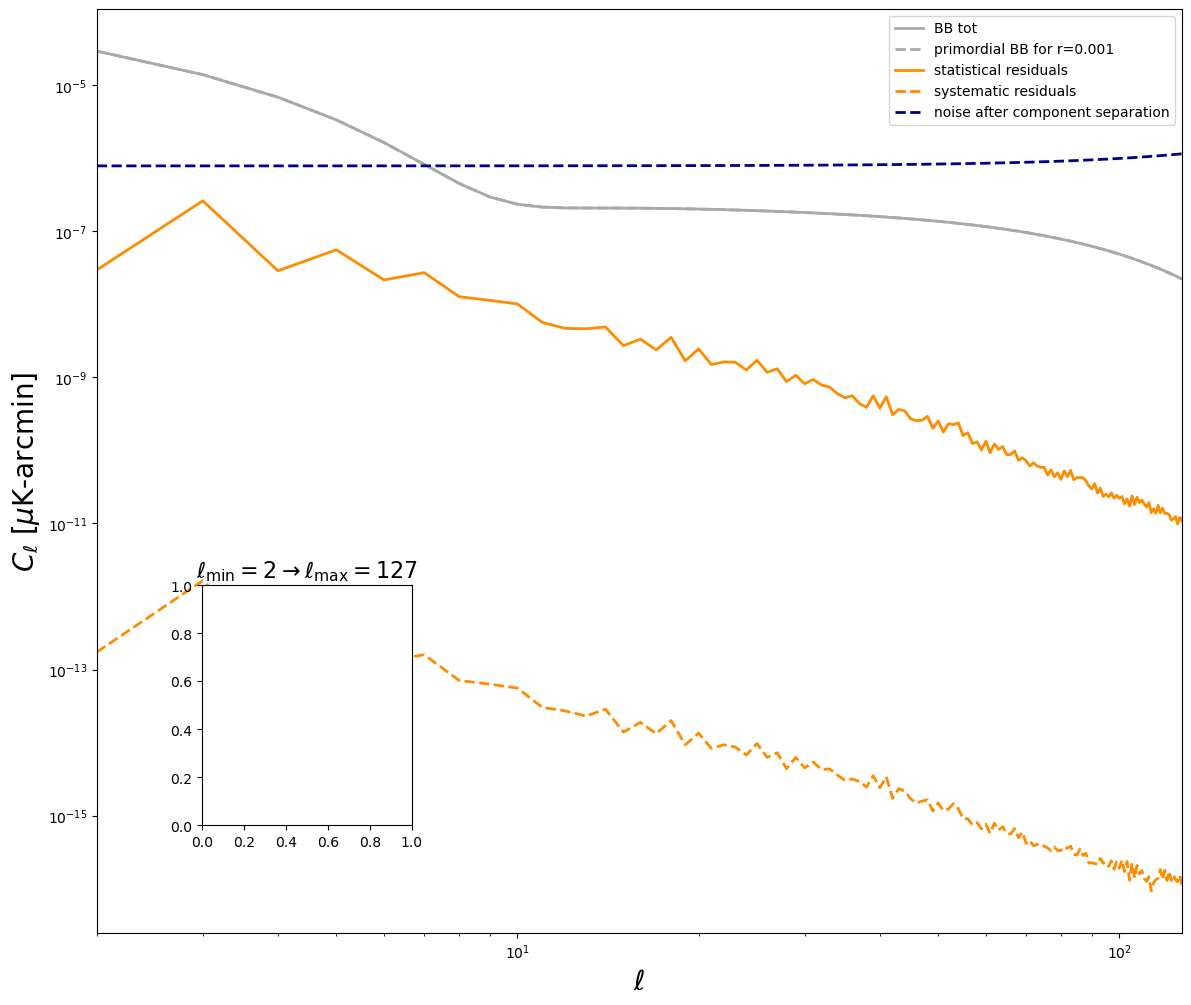

In [7]:
nside = 64
model = 'd0s0'


components= [CMB(), Dust(150.), Synchrotron(150.)]

instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

d_fgs_N = get_observation(instrument, model, noise=True, nside=nside)
d_fgs = get_observation(instrument, model, noise=False, nside=nside)

#take only the Q and U, not I
freq_maps_N= d_fgs_N[:,1:,:]
freq_maps= d_fgs[:,1:,:]

n_stokes = freq_maps.shape[1]
n_freqs = freq_maps.shape[0]

lmin=2
lmax= 2*nside-1




xForecast(components, instrument, freq_maps, lmin, lmax,Alens=0.0, r=0.001, make_figure=True)